In [1]:
import pandas as pd
import networkx as nx

In [ ]:
# Function to load data from a .jsonl file
def load_data_from_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data


# Load the dataset
dataset1 = load_data_from_jsonl('./mednli-a-natural-language-inference-dataset-for-the-clinical-domain-1.0.0/mli_train_v1.jsonl')
dataset2 = load_data_from_jsonl('./mednli-a-natural-language-inference-dataset-for-the-clinical-domain-1.0.0/mli_dev_v1.jsonl')
dataset3 = load_data_from_jsonl('./mednli-a-natural-language-inference-dataset-for-the-clinical-domain-1.0.0/mli_test_v1.jsonl')
print("First record in the dataset:", dataset1[0])

In [ ]:
# all concepts on each line will be connected in resulting knowledge graph
# save all concepts in a file for CliNER
with open("mednli_sentences.txt", "w") as f:
    for record in dataset1 + dataset2 + dataset3:
        if record['gold_label'] == "neutral":
            f.write(record['sentence1'] + "\n")
            f.write(record['sentence2'] + "\n")
        else:
            f.write(record['sentence1'] + " " + record['sentence2'] + "\n")

In [ ]:
! python cliner predict --txt data/examples/mednli_sentences.txt --out data/predict_mednli --model models/silver.crf --format i2b2

In [10]:
# parse the concepts output by CliNER
with open("./CliNER/data/predict_mednli/mednli_sentences.con", "r") as f:
    sentences = f.readlines()

concept_list = []
for sentence in sentences:
    word = sentence.split('"')[1]
    label = sentence.split('"')[3]
    group = sentence.split()[1].split(":")[0]
    concept_list.append([word, label, group])

df = pd.DataFrame(concept_list, columns=["word", "label", "group"])
concept_set = set(df["word"].tolist())
df.shape, len(concept_set)

((28070, 3), 8985)

In [41]:
import requests
import time
from tqdm import tqdm

# Load API key
with open("api-key.txt", "r") as f:
    # from https://uts.nlm.nih.gov/uts/profile, need free UMLS license. We had from BMI701
    api_key = f.read().strip()

# Function to query UMLS API and save concept ID
def get_concept_id(disease_name, log):
    base_url = 'https://uts-ws.nlm.nih.gov/rest/search/current'
    params = {
        'apiKey': api_key,
        'string': disease_name,
        'partialSearch': 'true',
        'pageSize': 2,
        # 'sabs': 'SNOMEDCT_US', # need to restrict mapping to UMLS concepts to match primeKG
    }

    response = requests.get(base_url, params=params)
    time.sleep(0.1) # API limit is 20 requests per second
    if response.status_code == 200:
        data = response.json()
        if 'result' in data and len(data['result']['results']) > 0:
            # Extract the first concept ID from the result
            concept_id = data['result']['results'][0]['ui']
            concept_name = data['result']['results'][0]['name']
            concept_source = data['result']['results'][0]['rootSource']
            return [concept_id, concept_name, concept_source]
        else:
            # print(f"No results found for {disease_name}")
            log.append(disease_name)
    else:
        print(f"Error querying UMLS API for {disease_name}. Status code: {response.status_code}")
        log.append(disease_name)
    return None

# Dictionary to store disease names and their corresponding concept IDs
disease_concept_ids = {}
log = []

# Iterate through each disease name and get concept ID with a timeout
for disease_name in tqdm(concept_set):
    # Remove lingering leading articles and pronouns
    if (
        disease_name.startswith("a ") or 
        disease_name.startswith("an ") or
        disease_name.startswith("his ") or 
        disease_name.startswith("her ") or 
        disease_name.startswith("the ") or
        disease_name.startswith("__num__ ")
    ):
        disease_name = disease_name.split(" ", 1)[1]
    if len(disease_name) < 2:
        continue
    concept = get_concept_id(disease_name, log)
    
    if concept is not None:
        disease_concept_ids[disease_name] = concept


 51%|█████     | 4541/8985 [49:48<1:01:18,  1.21it/s]

In [49]:
len(disease_concept_ids), len(log), len(concept_set) - len(disease_concept_ids)

(8455, 44, 530)

In [45]:
# save the concept ids to a file in case of crash
import json

with open('concept_matched.json', 'w') as fp:
    json.dump(disease_concept_ids, fp)
with open("log.txt", "w") as f:
    f.write("\n".join(log))

<Axes: >

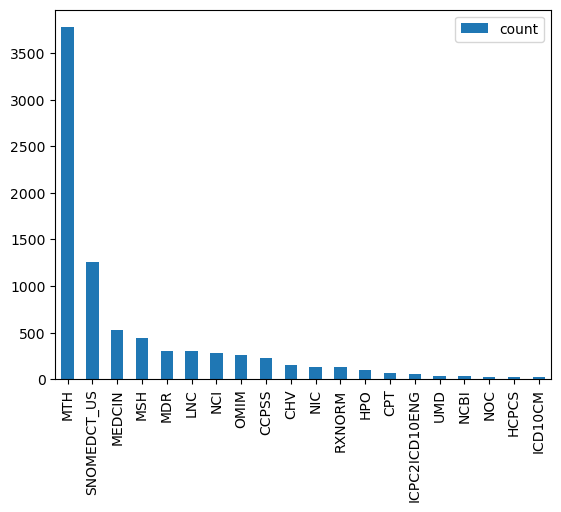

In [90]:
# check unique concepts
umls_concept_set = set()
for con in disease_concept_ids:
    umls_concept_set.add(disease_concept_ids[con][0])
umls_concept_list = list(umls_concept_set)
len(umls_concept_set)

# check unqiue sources
umls_source_dict = {}
for con in disease_concept_ids:
    if disease_concept_ids[con][2] not in umls_source_dict:
        umls_source_dict[disease_concept_ids[con][2]] = 1
    else:
        umls_source_dict[disease_concept_ids[con][2]] += 1

# convert dict to dataframe for plotting
umls_source_df = pd.DataFrame.from_dict(umls_source_dict, orient='index')
umls_source_df.columns = ['count']
umls_source_df = umls_source_df.sort_values(by=['count'], ascending=False)
umls_source_df.head(20).plot.bar()


In [98]:
graph_edges = set()
for group in tqdm(df["group"].unique()):
    # print(group)
    df_group = df[df["group"] == group]
    concepts = set()
    for word in df_group["word"].unique():
        # reintroduce chunk as I accidentally updated concept key
        if (
            word.startswith("a ") or 
            word.startswith("an ") or
            word.startswith("his ") or 
            word.startswith("her ") or 
            word.startswith("the ") or
            word.startswith("__num__ ")
        ):
            word = word.split(" ", 1)[1]
        if word not in disease_concept_ids:
            continue
        concepts.add(disease_concept_ids[word][1])
    concepts = sorted(list(concepts))
    for i in range(len(concepts)):
        for j in range(i+1, len(concepts)):
            graph_edges.add((concepts[i], concepts[j]))

print(len(graph_edges))
       

100%|██████████| 9213/9213 [00:07<00:00, 1236.99it/s]

36264


In [99]:
G = nx.from_edgelist(graph_edges)
print(G.number_of_nodes(), G.number_of_edges())

4336 36264


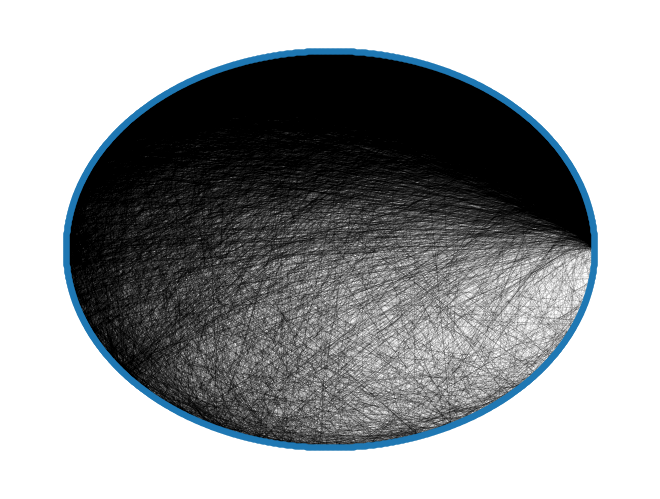

In [103]:
nx.draw_circular(G, alpha=0.5,node_size=10, width=0.1, )

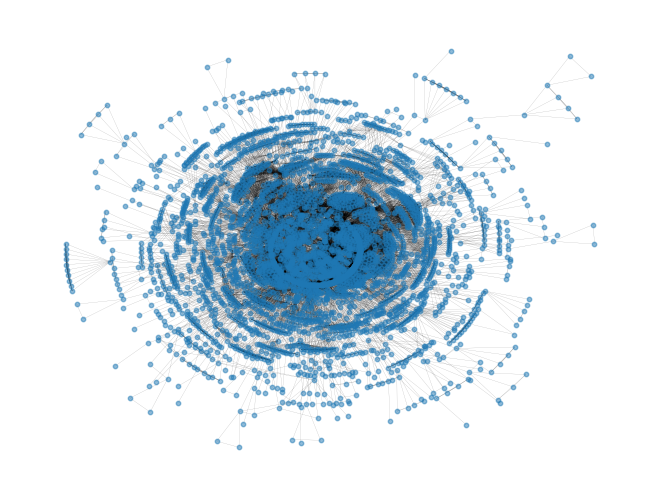

In [104]:
nx.draw_kamada_kawai(G, alpha=0.5,node_size=10, width=0.1, )

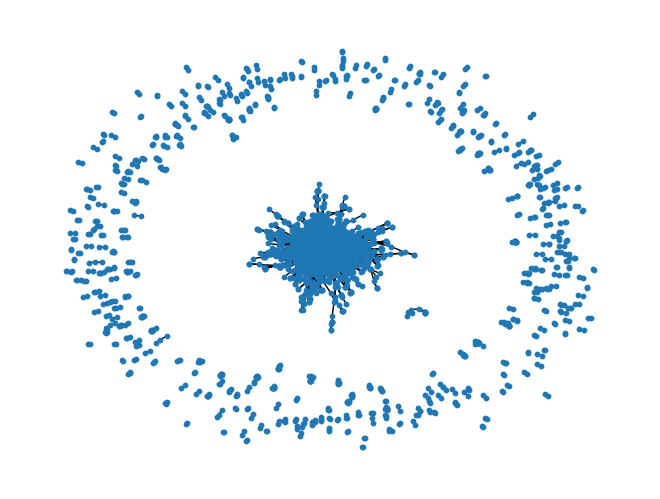

In [108]:
# nx draw with labels
# pos = nx.spring_layout(G)
nx.draw(G, node_size=10)

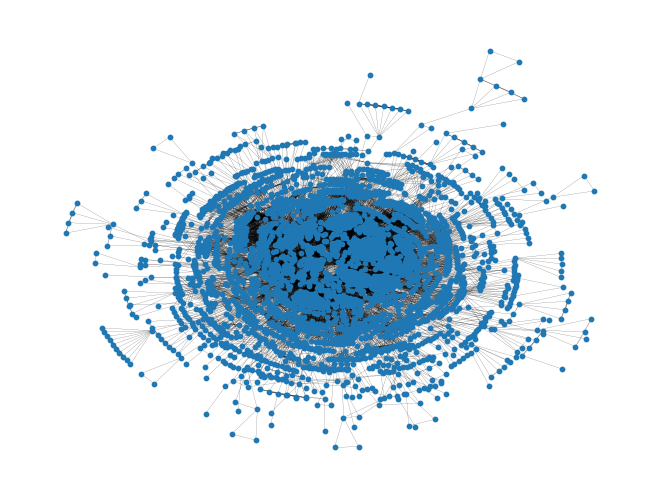

In [116]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
nx.draw_kamada_kawai(G0, node_size=10, width=0.1)

In [111]:
nx.number_connected_components(G)

359

In [117]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:40]

[('Chest discomfort', 192),
 ('Dyspnea', 185),
 ('Pain of lower extremities', 170),
 ('Monitor for proper functioning of device, correct placement in the pleural space, and tube patency (i.e., respiratory swing or fluid oscillating as patient breathes, either in tube or at the fluid meniscus)',
  170),
 ('CT of abdomen', 161),
 ('Deep vein thrombosis of lower limb', 151),
 ('narrowing; carotid artery, bilateral', 151),
 ('Pain in right arm', 148),
 ('chest pain accompanied by palpitations', 142),
 ('Anterior descending branch of left coronary artery', 139),
 ('Lung Problem', 137),
 ('Blood in stool', 136),
 ('Monitor for complications (e.g., blurred vision, confusion, dizziness, syncope, pallor, cold sweating, tachycardia, dizziness, drowsiness, weakness, altered level of consciousness, seizure, shortness of breath, chest pain)',
  131),
 ('Tachycardia', 128),
 ('Intracranial Hemorrhage', 128),
 ('Pleural effusion (disorder)', 127),
 ('Hypertensive disease', 127),
 ('P & S', 127),
 ('N

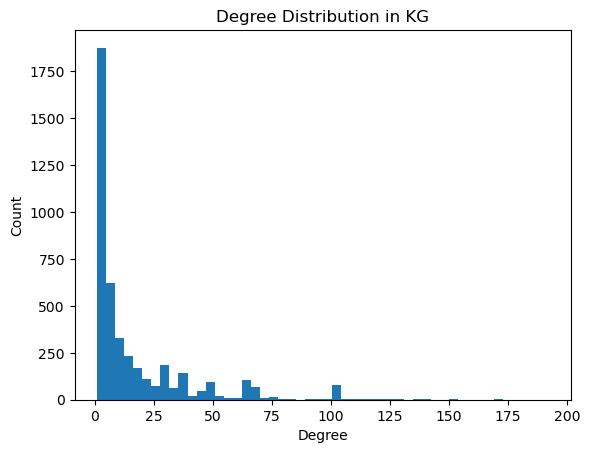

In [132]:
# plot degree distribution
import matplotlib.pyplot as plt
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=50)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.title("Degree Distribution in KG")
plt.savefig("degree_distribution.png")
plt.show()

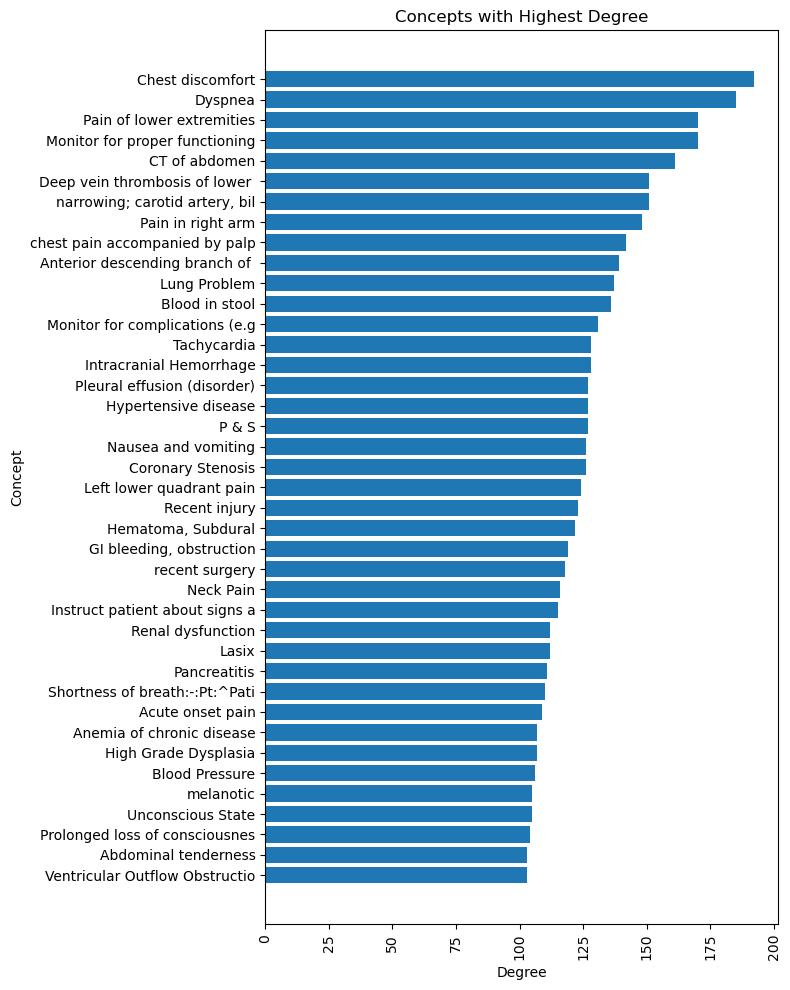

In [130]:
highest_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)[:40][::-1]
highest_degree_df = pd.DataFrame(highest_degree, columns=["concept", "degree"])
highest_degree_df["concept"] = highest_degree_df["concept"].str[:30]
plt.figure(figsize=(8, 10))
plt.barh(highest_degree_df["concept"], highest_degree_df["degree"])
plt.xticks(rotation=90)
plt.ylabel("Concept")
plt.xlabel("Degree")
plt.title("Concepts with Highest Degree")
plt.tight_layout()
plt.savefig("highest_degree.png", dpi=200)
plt.show()

In [114]:
sorted(G.degree, key=lambda x: x[1], reverse=False)[:40]

[('Gross blood', 1),
 ('Vomiting blood - fresh', 1),
 ('High flow oxygen nasal cannula', 1),
 ('Low flow state', 1),
 ('Diffuse cerebrovascular disease', 1),
 ('PTCA proximal circumflex lesion classification', 1),
 ('NARCOTIC LOW TOLERANCE', 1),
 ('Narcotic addiction medicine specialty with chronic pain management', 1),
 ('Prior Radiation Therapy', 1),
 ('Repeat', 1),
 ('Cardizem', 1),
 ('Fracture of multiple ribs', 1),
 ('Multiple rib fractures, unspecified', 1),
 ('Unspecified Abortion', 1),
 ('Endocarditis', 1),
 ('CT angiography of thorax with contrast', 1),
 ('Patient is not eligible for the referral for otologic evaluation measure (e.g., patients who are already under the care of a physician for acute or chronic dizziness)',
  1),
 ('C-SSRS Already Enrolled Subjects - Interrupted Suicide Attempt (Prior to Study Entry)',
  1),
 ('Suicide/suicide attempt', 1),
 ('Staphylococcal Infections', 1),
 ('Swelling', 1),
 ('Principal care management services, for a single high-risk disease,

In [131]:
nx.write_edgelist(G, "umls_kg.edgelist")

#### mapping to PrimeKG (WIP)

#TODO: match MedNLI concepts with MONDO / Specific disease/drug concepts used in PrimeKG for comparison

In [50]:
import pandas as pd
primekg = pd.read_csv('primekg.csv', low_memory=False)
primekg.query('y_type=="disease"|x_type=="disease"').shape

(618100, 12)

In [112]:
primekg.query('x_type=="disease" & (x_name.str.lower().str.contains("insulin"))')

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
3084937,disease_phenotype_negative,phenotype absent,27694,17994,disease,severe early-onset obesity-insulin resistance ...,MONDO,24475,2910,effect/phenotype,Elevated hepatic transaminase,HPO
3084938,disease_phenotype_negative,phenotype absent,27694,17994,disease,severe early-onset obesity-insulin resistance ...,MONDO,25526,3074,effect/phenotype,Hyperglycemia,HPO
3085074,disease_phenotype_negative,phenotype absent,27764,9416,disease,hypoinsulinemic hypoglycemia and body hemihype...,MONDO,22497,2960,effect/phenotype,Autoimmunity,HPO
3085075,disease_phenotype_negative,phenotype absent,27764,9416,disease,hypoinsulinemic hypoglycemia and body hemihype...,MONDO,90673,30781,effect/phenotype,Increased circulating free fatty acid level,HPO
3093356,disease_phenotype_positive,phenotype present,28314,14535,disease,hyperproinsulinemia,MONDO,25526,3074,effect/phenotype,Hyperglycemia,HPO
...,...,...,...,...,...,...,...,...,...,...,...,...
6056212,disease_disease,parent-child,98643,19334,disease,autosomal recessive hyperinsulinism due to Kir...,MONDO,38643,15624_17186_19265_15625_17187,disease,diazoxide-resistant hyperinsulinism,MONDO_grouped
6060032,disease_disease,parent-child,83935,24677,disease,pancreatic insulinoma,MONDO,37475,23206,disease,functional pancreatic neuroendocrine tumor,MONDO
6060033,disease_disease,parent-child,83935,24677,disease,pancreatic insulinoma,MONDO,32272,5048,disease,pancreatic insulin-producing neuroendocrine tumor,MONDO
6060684,disease_disease,parent-child,99685,34110,disease,atypical Fanconi syndrome-neonatal hyperinsuli...,MONDO,35764,5240,disease,kidney disease,MONDO


In [55]:
disease_concept_ids['cellulitis.']

['C0007642', 'Cellulitis', 'MTH']